In [4]:
!pip install -q datasets transformers

In [5]:
from datasets import load_dataset 

dataset = load_dataset("fashion_mnist")

Extracting data files #1:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #2:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #0:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #3:   0%|          | 0/1 [00:00<?, ?obj/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
from datasets import load_metric

metric = load_metric("accuracy")

<ipython-input-6-350fcae91df9>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [8]:
example=dataset["train"][0]

In [9]:
dataset["train"].features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)}

In [10]:
example['image']

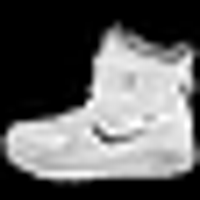

In [11]:
example['image'].resize((200, 200))

In [12]:
example['label']

9

In [13]:
dataset["train"].features["label"]

ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)

In [14]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

id2label[2]

'Pullover'

In [15]:
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
feature_extractor

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

ViTFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "size": 224
}

In [16]:
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
_transforms = Compose([RandomResizedCrop(feature_extractor.size), ToTensor(), normalize])

In [17]:
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

In [18]:
dataset = dataset.with_transform(transforms)

In [19]:
dataset['train'][0]

{'label': 9,
 'pixel_values': tensor([[[-1.0000, -1.0000, -1.0000,  ...,  0.7333,  0.7333,  0.7333],
          [-1.0000, -1.0000, -1.0000,  ...,  0.7333,  0.7333,  0.7333],
          [-1.0000, -1.0000, -1.0000,  ...,  0.7333,  0.7333,  0.7333],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],
 
         [[-1.0000, -1.0000, -1.0000,  ...,  0.7333,  0.7333,  0.7333],
          [-1.0000, -1.0000, -1.0000,  ...,  0.7333,  0.7333,  0.7333],
          [-1.0000, -1.0000, -1.0000,  ...,  0.7333,  0.7333,  0.7333],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],
 
         [[-1.0000, -1.0000, -1.0000,  ...,  0.7333,  0.7333,  0.7333],

In [20]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

In [21]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes = True,
)

Downloading:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
model_checkpoint='google/vit-base-patch16-224-in21k'
batch_size = 32 

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=16,
    evaluation_strategy="steps",
    num_train_epochs=4,
    fp16=True,
    save_steps=100,
    eval_steps=100,
    logging_steps=10,
    learning_rate=2e-4,
    save_total_limit=2,
    remove_unused_columns=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=feature_extractor,
)

trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 60000
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 15000
  Number of trainable parameters = 85806346


Step,Training Loss,Validation Loss
100,0.512400,0.654455
200,0.341600,0.647906
300,0.529800,0.601065
400,0.503100,0.608353
500,0.449400,0.598983
600,0.334500,0.571863
700,0.576100,0.629804
800,0.521100,0.539424
900,0.578400,0.694452
1000,0.502000,0.542580


***** Running Evaluation *****
  Num examples = 10000
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-100
Configuration saved in ./results/checkpoint-100/config.json
Model weights saved in ./results/checkpoint-100/pytorch_model.bin
Feature extractor saved in ./results/checkpoint-100/preprocessor_config.json
Deleting older checkpoint [results/checkpoint-200] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 10000
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-200
Configuration saved in ./results/checkpoint-200/config.json
Model weights saved in ./results/checkpoint-200/pytorch_model.bin
Feature extractor saved in ./results/checkpoint-200/preprocessor_config.json
Deleting older checkpoint [results/checkpoint-300] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 10000
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-300
Configuration saved in ./results/checkpoint-300/config.json
Model

In [ ]:
metrics = trainer.evaluate()
# some nice to haves:
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)